# Three-Homolog, replicate fits

**Set the visible devices for GPU training**

In [31]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [32]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Read in the dms data and list all available experimental conditions**

In [33]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../data/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../data/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [34]:
print(f"Available conditions for fitting are: {list(func_score_data.condition.unique())}")

Available conditions for fitting are: ['Delta-1', 'Delta-3', 'Delta-4', 'Delta-2', 'Omicron_BA1-1', 'Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-1', 'Omicron_BA2-2']


## Pre-Proccessing

In [35]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
func_score_df.aa_substitutions.fillna("", inplace=True)
func_score_df.sort_values(by="condition", inplace=True)
func_score_df.info()

  0%|          | 0/16 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135096 entries, 0 to 1135095
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   library                      1135096 non-null  object 
 1   pre_sample                   1135096 non-null  object 
 2   post_sample                  1135096 non-null  object 
 3   barcode                      1135096 non-null  object 
 4   func_score                   1135096 non-null  float64
 5   func_score_var               1135096 non-null  float64
 6   pre_count                    1135096 non-null  int64  
 7   post_count                   1135096 non-null  int64  
 8   pre_count_wt                 1135096 non-null  int64  
 9   post_count_wt                1135096 non-null  int64  
 10  pseudocount                  1135096 non-null  float64
 11  n_codon_substitutions        1135096 non-null  int64  
 12  aa_substitutions_sequential  986419 non-nu

In [36]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "pseudocount" : 0.1,
    "sample" : False,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "trim" : False
}

**Optionally subset the variants**

In [37]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

In [38]:
func_score_df

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAAATTCATTATGTTC,-0.9244,0.0006,11079,5259,1187006,1069422,0.5,4,R212G N437- A844H L1242-,4,R214G N439- A846H L1244-,23,Delta,1,Delta-1
60179,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,GAATGGTATGGCCGCG,0.4364,0.0089,521,428,1154532,701032,0.5,7,L10V G75D Y447N R680W A827S A1018D V1226E,7,L10V G75D Y449N R682W A829S A1020D V1228E,23,Delta,2,Delta-1
60178,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,CTGTCTAACGCCTACC,-1.8556,0.0278,521,87,1154532,701032,0.5,5,P25S Y363H A769N S811P,4,P25S Y365H A771N S813P,23,Delta,2,Delta-1
60177,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,CGGCGTGACTCAATTC,-0.0470,0.0108,521,306,1154532,701032,0.5,1,R679S,1,R681S,23,Delta,2,Delta-1
60176,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,CGCACCAAAATTACAT,1.2236,0.0068,521,739,1154532,701032,0.5,3,V70N S98G V143I,3,V70N S98G V143I,23,Delta,2,Delta-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930493,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAAGAACCAATACCTA,-0.7129,0.0183,287,187,9244303,9882108,0.5,4,P79S S109T D135T K1035N,4,P82S S112T D138T K1038N,69,Omicron_BA2,1,Omicron_BA2-2
930494,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAAGAGTAGTTTATGC,-0.8500,0.0194,287,170,9244303,9882108,0.5,4,L176P A219T G258H N402D,4,L179P A222T G261H N405D,69,Omicron_BA2,1,Omicron_BA2-2
930495,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAATATATGCCCAAAC,-2.3933,0.0428,287,58,9244303,9882108,0.5,2,S24F G410E,2,S27F G413E,69,Omicron_BA2,1,Omicron_BA2-2
930497,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAATTAAGTTTGATAA,0.6685,0.0115,287,488,9244303,9882108,0.5,2,A219V S1239I,2,A222V S1242I,69,Omicron_BA2,1,Omicron_BA2-2


**Drop all variants with pre-counts below a threshold.**

In [39]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
if prep_params["min_pre_counts"] == "bernadeta":
    func_score_df = func_score_df[func_score_df['pre_count'] >= func_score_df['pre_count_threshold']]
else:
    func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]

print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than the threshold of counts before selection, and were filtered out")

Of 1135096 variants, 120164 had fewer than the threshold of counts before selection, and were filtered out


In [40]:
func_score_df = func_score_df[['func_score', 'aa_substitutions', 'condition']].copy()

**remove all variants with string sites and stop codon wildtypes**

In [41]:
func_score_df.aa_substitutions.fillna("", inplace=True)
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/1014932 [00:00<?, ?it/s]

In [42]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

**Optionally, clip the target functional scores**

In [43]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

## Experiments

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

In [44]:
datasets = pd.DataFrame()

**Choose the libraries you would like in each of the two replicates**

In [ ]:
rep1_name_map = {
    "Delta-2":"Delta", 
    "Omicron_BA1-2":"Omicron_BA1",
    "Omicron_BA2-1":"Omicron_BA2"
}
fs_rep1 = func_score_df.query("condition in @rep1_name_map.keys()").copy()
fs_rep1["condition"] = fs_rep1.condition.replace(rep1_name_map)

rep2_name_map = {
    "Delta-4":"Delta", 
    "Omicron_BA1-3":"Omicron_BA1",
    "Omicron_BA2-2":"Omicron_BA2"
}
fs_rep2 = func_score_df.query("condition in @rep2_name_map.keys()").copy()
fs_rep2["condition"] = fs_rep2.condition.replace(rep2_name_map)

for reference in ["Omicron_BA1"]: # can add 'Delta' if you would like to 
    for rep_fsdf in [fs_rep1, fs_rep2]:       
        
        start = time.time()
        data = multidms.MultiDmsData(
            rep_fsdf,
            alphabet= multidms.AAS_WITHSTOP_WITHGAP,
            condition_colors = sns.color_palette("colorblind"),
            reference=reference,
            assert_site_integrity = False,
            verbose=False
        )
        
        end = time.time()
        prep_time = round(end-start)
        print(f"Finished, time: {prep_time}")
        
        prep_params['conditions'] = tuple(rep_fsdf.condition.unique())
        prep_params['time_to_prep'] = prep_time
        prep_params['reference'] = reference
        data_row = pd.Series(prep_params).to_frame().T
        data_row['data'] = data
        datasets = pd.concat([datasets, data_row], ignore_index=True)
    

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 42


In [ ]:
datasets

In [ ]:
import matplotlib.colors as colors

palette = [
    '#BFBFBF',#,'#404040',
    '#F97306',#, '#FFA500',
    '#9400D3'#, '#EE82EE',
]

conditions = [
    "Delta",# "Delta-3",
    "Omicron_BA1",# "Omicron_BA.1-3",
    "Omicron_BA2"#, "Omicron_BA.2-2"
]
cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}

for row, values in datasets.iterrows():
    values.data.condition_colors = cc

In [18]:
def fit_wrapper(
    dataset,
    δ_huber = 1,
    λ_lasso_shift = 2e-5,
    λ_ridge_beta = 1e-6,
    λ_ridge_shift = 1e-6,
    λ_ridge_gamma = 1e-3,
    data_idx = 0,
    epistatic_model = "identity",
    output_activation = "identity",
    lock_beta = False, 
    lock_C_ref = False,
    gamma_corrected = True,
    conditional_c = False,
    init_C_ref = 0.0,
    warmup_beta = False,
    num_training_steps = 10,
    iterations_per_step = 2000,
    save_model_at = [2000, 10000, 20000]
):
    
    fit_attributes = locals().copy()
    biophysical_model = {
        "identity" : multidms.model.identity_activation,
        "Sigmoid" : multidms.model.sigmoidal_global_epistasis,
        "Softplus" : multidms.model.softplus_activation
    }
    
    
    imodel = multidms.MultiDmsModel(
        dataset,
        epistatic_model=biophysical_model[fit_attributes['epistatic_model']],
        output_activation=biophysical_model[fit_attributes['output_activation']],
        conditional_c=fit_attributes['conditional_c'],
        gamma_corrected=fit_attributes['gamma_corrected'],
        init_C_ref=fit_attributes['init_C_ref']
    )

    if fit_attributes["warmup_beta"]:
        imodel.fit_reference_beta()

    lock_params = {}
    if fit_attributes["lock_beta"]:
        lock_params["β"] = imodel.params["β"]

    if fit_attributes["lock_C_ref"]:
        lock_params["C_ref"] = jnp.zeros(shape=(1,))

    fit_attributes['epoch_loss'] = []
    print(f"running:")
    pprint.pprint(fit_attributes)

    fit_attributes["total_iterations"] = 0
    ret = pd.DataFrame()

    for training_step in range(num_training_steps):

        start = time.time()
        imodel.fit(
            lasso_shift=fit_attributes['λ_lasso_shift'],
            λ_ridge_shift=fit_attributes['λ_ridge_shift'],
            λ_ridge_beta=fit_attributes['λ_ridge_beta'],
            λ_ridge_gamma=fit_attributes['λ_ridge_gamma'],
            maxiter=iterations_per_step, 
            tol=1e-6,
            δ=fit_attributes["δ_huber"],
            lock_params=lock_params
        )
        end = time.time()

        fit_time = round(end - start)
        fit_attributes['total_iterations'] += iterations_per_step
        fit_attributes['epoch_loss'].append(float(imodel.loss))

        print(
            f"training_step {training_step}/{num_training_steps}, Loss: {imodel.loss}, Time: {fit_time} Seconds",
            flush=True
        )

        if fit_attributes['total_iterations'] in save_model_at:
            data_row = pd.Series(fit_attributes).to_frame().T
            data_row["model_object"] = copy.copy(imodel)
            ret = pd.concat([ret, data_row], ignore_index=True)
            
    return ret


def plot_loss2(models):

    fig, ax = plt.subplots(figsize=[7,7])
    iterations = [(i+1)*2000 for i in range(10)]
    for group, group_models in models.groupby(
        ['λ_ridge_beta', 'λ_ridge_shift', 'warmup_beta', 'lock_beta', 'conditional_c', 'δ_huber']
    ):
        max_iter_model = group_models[group_models['total_iterations']==group_models['total_iterations'].max()]
        

        for mt, mt_df in max_iter_model.groupby(["epistatic_model", "output_activation"]):

            assert len(mt_df) == 1
            if mt != ("identity", "identity"):
                style = "--"
                lp = "\n".join(mt)
            else:
                style = "-"
                lp = "linear model"

            lw = 3 if group[5] != 3 else 5

            loss = mt_df['epoch_loss'].values

            ax.plot(
                iterations, 
                loss[0],
                lw=lw,
                linestyle = style,
                label=f"{lp}\nλ ridge beta: {group[0]} | λ ridge shift: {group[1]}\n warmup: {group[2]}\nlock_beta: {group[3]} | conditional_c: {group[4]}\nδ_huber:{group[5]}"
            )

    ax.set_ylabel(f"Loss")
    ax.set_xlabel(f"Iterations")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

    
def plot_loss_simple(models):

    fig, ax = plt.subplots(figsize=[7,7])
    iterations = [(i+1)*2000 for i in range(10)]
    for model, model_row in models.iterrows():

        loss = model_row['epoch_loss']

        ax.plot(
            iterations, 
            loss[0],
            lw=3,
            linestyle = "--",
            label=f"model: {model}"
        )

    ax.set_ylabel(f"Loss")
    ax.set_xlabel(f"Iterations")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
from functools import reduce
def combine_replicate_muts(fit_dict, times_seen_threshold=3):
    """
    Take a dictionary of fit objects, with key's as the prefix for individual
    replicate values, and merge then such that all individual and average mutation
    values are present in both.
    """

    # obtain and curate each of the replicate mutational dataframes
    mutations_dfs = []
    for replicate, fit in fit_dict.items():

        fit_mut_df = fit.mutations_df.set_index("mutation")

        new_column_name_map = {c: f"{replicate}_{c}" for c in fit_mut_df.columns}
        fit_mut_df = fit_mut_df.rename(new_column_name_map, axis=1)

        times_seen_cols = [c for c in fit_mut_df.columns if "times" in c]
        for c in times_seen_cols:
            fit_mut_df = fit_mut_df[fit_mut_df[c] >= times_seen_threshold]
        mutations_dfs.append(fit_mut_df)

    # merge each of the replicate mutational dataframes
    mut_df = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="inner"
        ),
        mutations_dfs,
    )

    column_order = []
    # now compute replicate averages
    for c in fit.mutations_df.columns:
        if c == "mutation" or "times_seen" in c:
            continue
        cols_to_combine = [f"{replicate}_{c}" for replicate in fit_dict.keys()]
        
        # just keep one replicate wt, site, mut .. as they are shared.
        if c in ["wts", "sites", "muts"]:
            mut_df[c] = mut_df[cols_to_combine[0]]
            mut_df.drop(cols_to_combine, axis=1, inplace=True)
            
        # take the average.
        else:
            mut_df[f"avg_{c}"] = mut_df[cols_to_combine].mean(axis=1)
            column_order += (cols_to_combine + [f"avg_{c}"])

    return mut_df.loc[:, ["wts", "sites", "muts"] + column_order]

In [19]:
datasets

,scale_counts,pseudocount,sample,min_pre_counts,clip_target,trim,conditions,time_to_prep,reference,data
0,False,0.1,5000,100,"(-3.5, 2.5)",False,"(Omicron_BA2, Omicron_BA1, Delta)",4,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f96b2...
1,False,0.1,5000,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1, Omicron_BA2)",5,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f96b2...


**Fit a model for each replicate (dataset)**

In [20]:
save_model_at = [2000, 6000, 10000, 40000]

In [21]:
models = pd.DataFrame()
for dataset in datasets.index.values:
    
    new = {
        'epistatic_model' : "Sigmoid",
        'output_activation' : "Softplus",
        'warmup_beta':True,
        'λ_ridge_beta':1e-6,
        'λ_ridge_shift':1e-6,
        'λ_ridge_gamma':1e-3,
        'save_model_at':save_model_at,
        'num_training_steps':20,
        'iterations_per_step':2000
    }

    models = pd.concat([
        models,
        fit_wrapper(datasets.loc[dataset, "data"], **new),
    ])

running:
{'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f96b2f0e1d0>,
 'epistatic_model': 'Sigmoid',
 'epoch_loss': [],
 'gamma_corrected': True,
 'init_C_ref': 0.0,
 'iterations_per_step': 2000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 1,
 'output_activation': 'Softplus',
 'save_model_at': [2000, 6000, 10000, 40000],
 'warmup_beta': True,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 1e-06,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 1e-06}
training_step 0/1, Loss: 0.033284048014572507, Time: 10 Seconds
running:
{'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f96b2f0e4d0>,
 'epistatic_model': 'Sigmoid',
 'epoch_loss': [],
 'gamma_corrected': True,
 'init_C_ref': 0.0,
 'iterations_per_step': 2000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 1,
 'output_activation': 'Softplus',
 'save_model_at': [2000, 6000, 10000, 40000],
 'warmup_beta': 

In [22]:
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,data_idx,epistatic_model,output_activation,lock_beta,...,gamma_corrected,conditional_c,init_C_ref,warmup_beta,num_training_steps,iterations_per_step,save_model_at,epoch_loss,total_iterations,model_object
0,<multidms.data.MultiDmsData object at 0x7f96b2...,1,0.00002,0.000001,0.000001,0.001,0,Sigmoid,Softplus,False,...,True,False,0.0,True,1,2000,"[2000, 6000, 10000, 40000]",[0.033284048014572507],2000,<multidms.model.MultiDmsModel object at 0x7f96...
0,<multidms.data.MultiDmsData object at 0x7f96b2...,1,0.00002,0.000001,0.000001,0.001,0,Sigmoid,Softplus,False,...,True,False,0.0,True,1,2000,"[2000, 6000, 10000, 40000]",[0.1205017395055688],2000,<multidms.model.MultiDmsModel object at 0x7f96...


**plot convergence of each model**

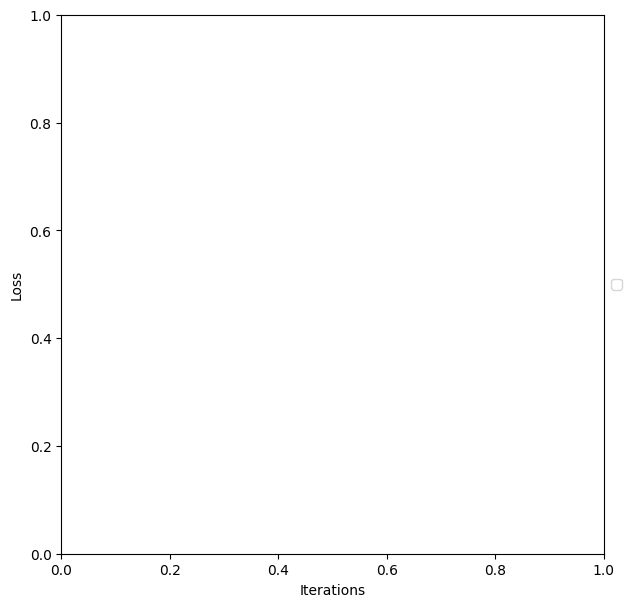

In [23]:
fig, ax = plt.subplots(figsize=[7,7])
iterations = [(i+1)*2000 for i in range(20)]
for model, model_row in models.iterrows():
    
    if model_row['total_iterations'] != 40000: continue

    loss = model_row['epoch_loss']
    reference = model_row['model_object'].data.reference
    
    
    ax.plot(
        iterations, 
        loss,
        lw=3,
        linestyle = "--",
        label=f"Reference: {reference}"
    )

ax.set_ylabel(f"Loss")
ax.set_xlabel(f"Iterations")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

**merge replicate mutation dataframes and write to disk**

In [24]:
# models.reset_index(drop=True, inplace=True)
# models["replicate"] = [0,1]

In [25]:
# fit_dict = {
#     "rep1" : models.loc[0, "model_object"],
#     "rep2" : models.loc[1, "model_object"]
# }
    
# models_mut_df = combine_replicate_muts(fit_dict)

# models_mut_df.to_csv("ref-delta-precutoff-100.csv", index=True)

# fit_dict = {
#     "rep1" : models.loc[0, "model_object"],
#     "rep2" : models.loc[1, "model_object"]
# }
    
# models_mut_df = combine_replicate_muts(fit_dict)

In [26]:
# models_mut_df.to_csv("ref-BA1-replicate-fit-mutation_df.csv", index=True)

In [27]:
full_fit_models = models.query("total_iterations == 40000")
full_fit_models = full_fit_models.assign(replicate = [0, 1])

In [28]:
full_fit_models.reset_index(drop=True, inplace=True)

In [29]:
# fit_dict = {
#     "rep1" : full_fit_models.loc[0, "model_object"],
#     "rep2" : full_fit_models.loc[1, "model_object"]
# }
    
# models_mut_df = combine_replicate_muts(fit_dict)

# models_mut_df.to_csv("ref-omicron-ridge-gamma.csv", index=True)

**plot model summary**

In [30]:
for idx, row in full_fit_models.iterrows():
    ref = row.model_object.data.reference
    rep = row.replicate
    print(f"Model Index: {idx} Reference: {ref} Replicate: {rep} =========================================== ")
    fig, ax = plt.subplots(1,2,figsize=[8,4])
    
    row.model_object.plot_pred_accuracy(ax=ax[0], show=False, alpha=0.08, legend=False)
    row.model_object.plot_epistasis(ax=ax[1], show=False, alpha=0.08)
    
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    for condition in row.model_object.data.conditions:
        if condition == row.model_object.data.reference: continue
        row.model_object.plot_shifts_by_site(condition, show=True, agg_func=onp.sum)
        row.model_object.plot_param_hist(f"S_{condition}", show=True)  

AttributeError: 'float' object has no attribute 'data'

**Generate an altair plot from a single model**

In [ ]:
models.loc[0, "model_object"].mut_shift_plot(include_beta=False)

**generate and altair plot that shows average value of replicates**

In [ ]:
multidms.plot.mut_shift_plot(full_fit_models, include_beta=False)